In [5]:
import numpy as np
import pandas as pd
import pdpipe as pdp

import shapely
#import geopandas as gpd

import seaborn as sns
import folium

In [47]:
nyc_b_sub = pd.read_csv("../fulldata/nyc_bikeshare.csv")
nyc_b_sub_orig = nyc_b_sub
nyc_b_sub.head()

,tripduration,starttime,stoptime,start_station_id,end_station_id,bikeid,usertype,birthyear,gender
0,2059,06-01-13 00:00:44,06-01-13 00:35:03,406.0,406.0,19599,0.0,NaN,0
1,1521,06-01-13 00:01:22,06-01-13 00:26:43,2008.0,310.0,15567,1.0,1983.0,1
2,2028,06-01-13 00:01:47,06-01-13 00:35:35,485.0,406.0,18445,0.0,NaN,0
3,1829,06-01-13 00:03:47,06-01-13 00:34:16,265.0,436.0,15234,1.0,1984.0,1
4,899,06-01-13 00:09:25,06-01-13 00:24:24,494.0,494.0,15539,1.0,1967.0,1


In [48]:
pipe = pdp.DropNa(subset=["start_station_id","end_station_id"])
nyc_bsub = pipe(nyc_b_sub)

In [13]:
id_to_nta = pd.read_csv("./id-to-nta.csv")
id_to_nta.head()

nta_num_hash = dict(zip(id_to_nta['station_id'], id_to_nta['nta_number']))

In [18]:
nta_to_num = pd.read_csv("./nta-to-num.csv")
nta_to_num.head()

nta_code_hash = dict(zip(nta_to_num['nta_number'], nta_to_num['nta']))

In [20]:
nyc_bsub['nta_start'] = nyc_bsub.apply(lambda row: nta_code_hash[nta_num_hash[row.start_station_id]], axis=1)
nyc_bsub['nta_end'] = nyc_bsub.apply(lambda row: nta_code_hash[nta_num_hash[row.end_station_id]], axis=1)

In [21]:
nyc_bsub.head()

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,end_station_id,usertype,birthyear,gender,nta_start,nta_end
0,21679149,299,01-23-19 19:49:23,01-23-19 19:54:23,432.0,266.0,1.0,1991.0,1,MN22,MN28
1,9972891,3733,09-11-16 15:59:59,09-11-16 17:02:12,457.0,469.0,0.0,NaN,0,MN17,MN17
2,4105739,628,12-29-14 14:29:28,12-29-14 14:39:56,153.0,468.0,1.0,1959.0,1,MN20,MN17
3,9909812,594,09-07-16 19:10:26,09-07-16 19:20:20,326.0,537.0,1.0,1978.0,2,MN22,MN21
4,15688970,199,11-05-17 11:07:48,11-05-17 11:11:07,3061.0,3064.0,1.0,1990.0,1,BK75,BK35


In [32]:
latlon = pd.read_csv('../fulldata/legends/nyc_bikeshare_key.csv')
lats = dict(zip(latlon['station_id'], latlon['station_latitude']))
lons = dict(zip(latlon['station_id'], latlon['station_longitude']))

lats
lons

{72: -73.99392888,
 79: -74.00666661,
 82: -74.00016545,
 83: -73.97632328,
 116: -74.00149746,
 119: -73.97803415,
 120: -73.95928168,
 127: -74.00674436,
 128: -74.00297088,
 137: -73.972924,
 143: -73.99337909,
 144: -73.98068914,
 146: -74.0091059,
 147: -74.01121978,
 150: -73.98085795,
 151: -73.99724901,
 152: -74.00910627,
 153: -73.9816324,
 157: -73.99612349,
 160: -73.978462,
 161: -73.99810231,
 164: -73.97032517,
 167: -73.97604882,
 168: -73.99456405,
 173: -73.98452729,
 174: -73.97738662,
 195: -74.01043382,
 212: -74.00681753,
 216: -73.99548059,
 217: -73.99383605,
 218: -73.98707105,
 223: -73.99994661,
 224: -74.00552427,
 225: -74.00803013,
 228: -73.97187886,
 229: -73.99379025,
 232: -73.99014892,
 233: -73.99052739,
 236: -73.98713956,
 237: -73.98672378,
 238: -74.00859207,
 239: -73.9813018,
 241: -73.97493121,
 242: -73.973736,
 243: -73.979382,
 244: -73.96536851,
 245: -73.97703874,
 247: -74.00483091,
 248: -74.00771779,
 249: -74.0090009,
 250: -73.995652

In [33]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r/1.609

In [ ]:
nyc_bsub['straight_distance'] = nyc_bsub.apply(lambda row: haversine(
    lats[row.start_station_id],
    lons[row.start_station_id],
    lats[row.end_station_id],
    lons[row.end_station_id]), axis=1)

In [35]:
nyc_bsub.head()

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,end_station_id,usertype,birthyear,gender,nta_start,nta_end,straight_distance
0,21679149,299,01-23-19 19:49:23,01-23-19 19:54:23,432.0,266.0,1.0,1991.0,1,MN22,MN28,0.558445
1,9972891,3733,09-11-16 15:59:59,09-11-16 17:02:12,457.0,469.0,0.0,NaN,0,MN17,MN17,0.095647
2,4105739,628,12-29-14 14:29:28,12-29-14 14:39:56,153.0,468.0,1.0,1959.0,1,MN20,MN17,0.252583
3,9909812,594,09-07-16 19:10:26,09-07-16 19:20:20,326.0,537.0,1.0,1978.0,2,MN22,MN21,0.204765
4,15688970,199,11-05-17 11:07:48,11-05-17 11:11:07,3061.0,3064.0,1.0,1990.0,1,BK75,BK35,0.424590


In [36]:
nyc_bsub.to_csv('nyc_bike_sub_with_distance.csv')

In [37]:
nyc_bsub['starttime'] = pd.to_datetime(nyc_bsub['starttime'])

In [39]:
grp_nyc_bsub = nyc_bsub.groupby(nyc_bsub['starttime'].dt.to_period('Q'))

In [41]:
b_m = grp_nyc_bsub.mean()[13:24]

In [43]:
b_m.reset_index(inplace=True)

[Text(0, 0, '2016Q3'),
 Text(0, 0, '2016Q4'),
 Text(0, 0, '2017Q1'),
 Text(0, 0, '2017Q2'),
 Text(0, 0, '2017Q3'),
 Text(0, 0, '2017Q4'),
 Text(0, 0, '2018Q1'),
 Text(0, 0, '2018Q2'),
 Text(0, 0, '2018Q3'),
 Text(0, 0, '2018Q4'),
 Text(0, 0, '2019Q1')]

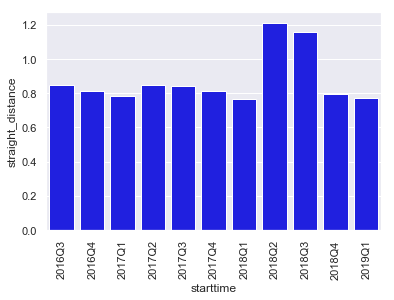

In [45]:
sns.set()
chart = sns.barplot(x='starttime', y='straight_distance', data=b_m, color='blue')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)